# Laboratorio 6 - Modsim
## Parte 4
Tiene la tarea de modelar el flujo de tráfico urbano a múltiples escalas, desde vehículos individuales hasta toda la ciudad. Implemente un modelo de flujo de tráfico multiescala en Python para analizar el comportamiento del tráfico y los patrones de congestión.

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
from IPython.display import display, Image as IPImage

In [48]:
class TrafficSign:
    def __init__(self, x, y, sign_type):
        self.position = np.array([x, y])
        self.sign_type = sign_type

In [54]:
class Vehicle:
    def __init__(self, x, y, speed, direction):
        self.position = np.array([x, y])
        self.velocity = np.array([speed, 0])
        self.acceleration = np.array([0, 0])
        self.direction = direction

    def update(self, vehicles, traffic_signs):
        # ----------------------------------------- REGLA 1 -----------------------------------------
        #                                acelerar al limite de velocidad
        #                                   y frenar prudentemente.
        # -------------------------------------------------------------------------------------------

        target_speed = 60
        max_acceleration = 2 

        speed_error = target_speed - np.linalg.norm(self.velocity)
        if speed_error > 0:
            acceleration = max_acceleration
        else:
            acceleration = -max_acceleration

        # ----------------------------------------- REGLA 2 -----------------------------------------
        #                                     no chocarse con otros
        #                                        y frenar suave.
        # -------------------------------------------------------------------------------------------
        safe_distance = 10 
        for other_vehicle in vehicles:
            if other_vehicle != self:
                distance = np.linalg.norm(other_vehicle.position - self.position)
                if distance < safe_distance:
                    acceleration -= max_acceleration / 2

        
        # ----------------------------------------- REGLA 3 -----------------------------------------
        #                                cambiar carriles prudentemente
        # -------------------------------------------------------------------------------------------
        safe_lane_change_distance = 20
        for other_vehicle in vehicles:
            if other_vehicle != self:
                relative_position = other_vehicle.position - self.position
                if 0 < relative_position[0] < safe_lane_change_distance and abs(relative_position[1]) < 2:
                    # Distancia segura y carril adyacente libre
                    self.position[1] = other_vehicle.position[1]


        # ----------------------------------------- REGLA 4 -----------------------------------------
        #                                señales de transito en la ciudad
        # -------------------------------------------------------------------------------------------
        for sign in traffic_signs:
            distance_to_sign = np.linalg.norm(sign.position - self.position)
            if distance_to_sign < 20:
                if sign.sign_type == "yield":
                    self.velocity[0] *= 0.8  # Reducción del 20% de la velocidad
                elif sign.sign_type == "u-turn":
                    self.direction = "backwards" if self.direction == "straight" else "straight"
                elif sign.sign_type == "left-only":
                    self.direction = "left"
                elif sign.sign_type == "right-only":
                    self.direction = "right"




        # ----------------------------------------- RETORNO -----------------------------------------

        if self.direction == "backwards":
            self.velocity[0] += (acceleration) * -1
            self.velocity[1] = 0
            self.position += self.velocity
            max_speed = 60  # Velocidad máxima en km/h
            self.velocity[0] = (min(self.velocity[0], max_speed)) * -1
            self.velocity[1] = 0


        elif self.direction == "straight":
            self.velocity[0] += acceleration
            self.velocity[1] = 0
            self.position += self.velocity
            max_speed = 60  # Velocidad máxima en km/h
            self.velocity[0] = min(self.velocity[0], max_speed)
            self.velocity[1] = 0


        elif self.direction == "left":
            self.velocity[1] += acceleration
            self.velocity[0] = 0
            self.position += self.velocity
            max_speed = 60  # Velocidad máxima en km/h
            self.velocity[1] = min(self.velocity[0], max_speed)
            self.velocity[0] = 0


        elif self.direction == "right":
            self.velocity[1] += (acceleration) * -1
            self.velocity[0] = 0
            self.position += self.velocity
            max_speed = 60  # Velocidad máxima en km/h
            self.velocity[1] = (min(self.velocity[0], max_speed)) * -1
            self.velocity[0] = 0

        

In [55]:
def generate_random_traffic_signs(num_signs, limx, limy):
    traffic_signs = []
    for _ in range(num_signs):
        x = random.uniform(0, limx)
        y = random.uniform(0, limy)
        sign_type = random.choice(["yield", "u-turn", "left-only", "right-only"])  # Tipo de señal aleatorio
        traffic_signs.append(TrafficSign(x, y, sign_type))
    return traffic_signs

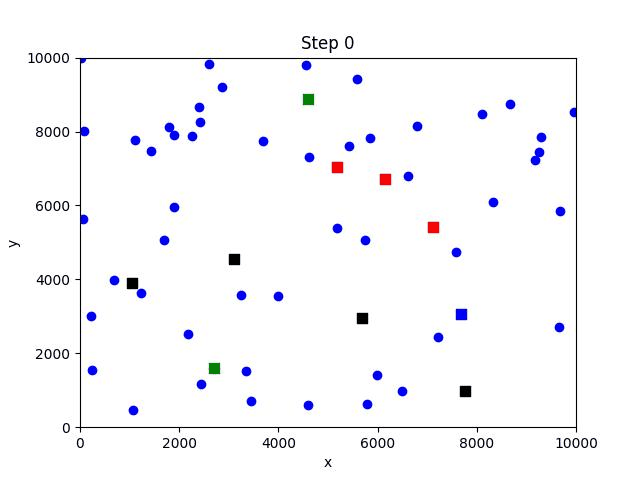

In [56]:
limx=10000
limy=10000

num_vehicles = 50
vehicles = [Vehicle(random.uniform(0, limx), random.uniform(0, limy), random.uniform(20, 80), random.choice(["straight", "backward", "left", "right"])) for _ in range(num_vehicles)]

num_traffic_signs = 10
traffic_signs = generate_random_traffic_signs(num_traffic_signs, limx, limy)

list_images = []
num_steps = 100
for step in range(num_steps):
    plt.clf()
    plt.xlim(0, limx)
    plt.ylim(0, limy)

    x=[]
    y=[]

    for vehicle in vehicles:
        vehicle.update(vehicles, traffic_signs)
        x.append(vehicle.position[0])
        y.append(vehicle.position[1])
    
    
    for sign in traffic_signs:
        sign_type = sign.sign_type
        if sign_type == "yield":
            color = "red"
        elif sign_type == "u-turn":
            color = "blue"
        elif sign_type == "left-only":
            color = "green"
        elif sign_type == "right-only":
            color = "black"
        else:
            color = "black"  # Color predeterminado para tipos desconocidos

        plt.scatter(sign.position[0], sign.position[1], c=color, marker='s', s=50)

    
    plt.plot(x, y, "bo")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Step " + str(step))
    name =  f"./E4_images/step_{step}.jpg"
    plt.savefig(name, format="jpg")
    plt.close()
    list_images.append(name)

images = [Image.open(path) for path in list_images]
gif_path = f"./E4_gifs/animation.gif"
images[0].save(gif_path, save_all=True, append_images=images[1:], loop=0, duration=300)
display(IPImage(filename=gif_path))
